# Imports and Summary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv('Walmart_sales.csv')
df.head()

,Store,Date,Weekly_Sales,Holiday_Flag,Temperature,Fuel_Price,CPI,Unemployment
0,1,05-02-2010,1643690.90,0,42.31,2.572,211.096358,8.106
1,1,12-02-2010,1641957.44,1,38.51,2.548,211.242170,8.106
2,1,19-02-2010,1611968.17,0,39.93,2.514,211.289143,8.106
3,1,26-02-2010,1409727.59,0,46.63,2.561,211.319643,8.106
4,1,05-03-2010,1554806.68,0,46.50,2.625,211.350143,8.106


First I'll get the date column into a datetime type so it's easier to split in a moment.

In [3]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6435 entries, 0 to 6434
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         6435 non-null   int64         
 1   Date          6435 non-null   datetime64[ns]
 2   Weekly_Sales  6435 non-null   float64       
 3   Holiday_Flag  6435 non-null   int64         
 4   Temperature   6435 non-null   float64       
 5   Fuel_Price    6435 non-null   float64       
 6   CPI           6435 non-null   float64       
 7   Unemployment  6435 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 402.3 KB


# Quick EDA
I did most of my actual EDA on the LassoCV model, but I have a few more nagging questions I'll check out here. 

It looks like there's an slight decrease in sales on average for higher number stores. That probably has to do with store locations with lower number stores being first-built and likely in more desnsely populated areas. I'll confirm the correlation shortly.

<Axes: xlabel='Store', ylabel='Weekly_Sales'>

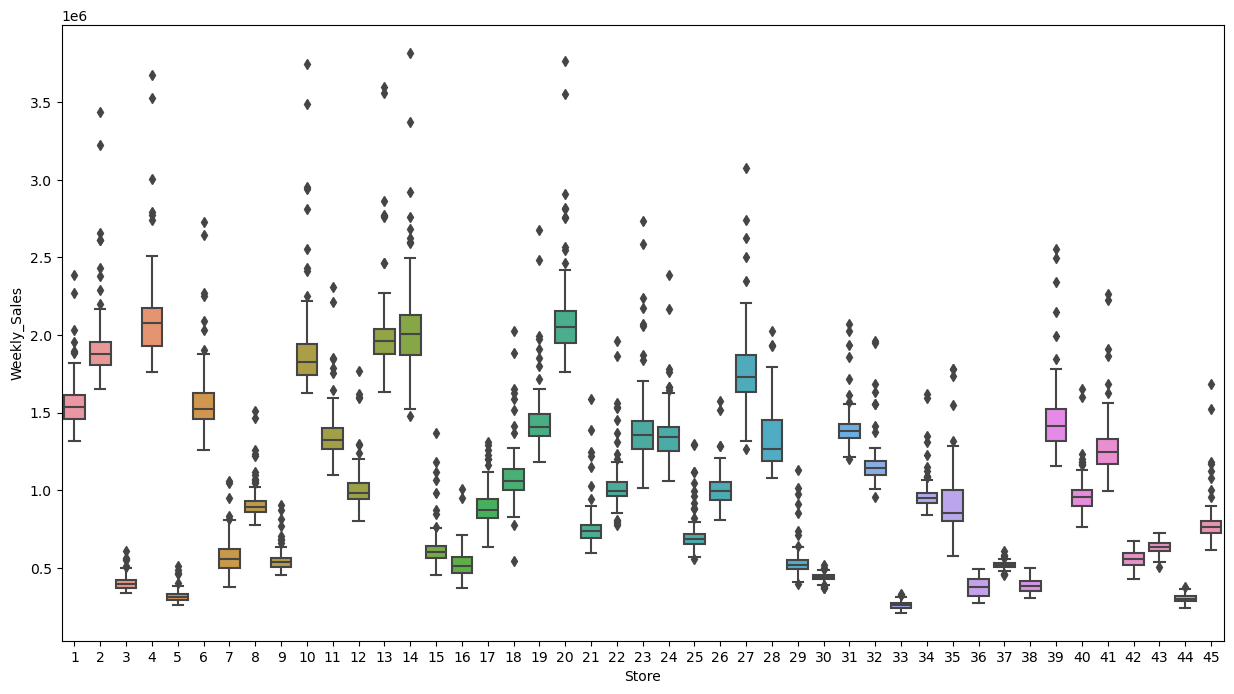

In [4]:
plt.figure(figsize=(15,8))
sns.boxplot(x = df['Store'], y = df['Weekly_Sales'])

Definitely holiday spikes here. I'll make sure the flag for holidays feature is inlcuded.

/Users/caseyfranco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/caseyfranco/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='Date', ylabel='Weekly_Sales'>

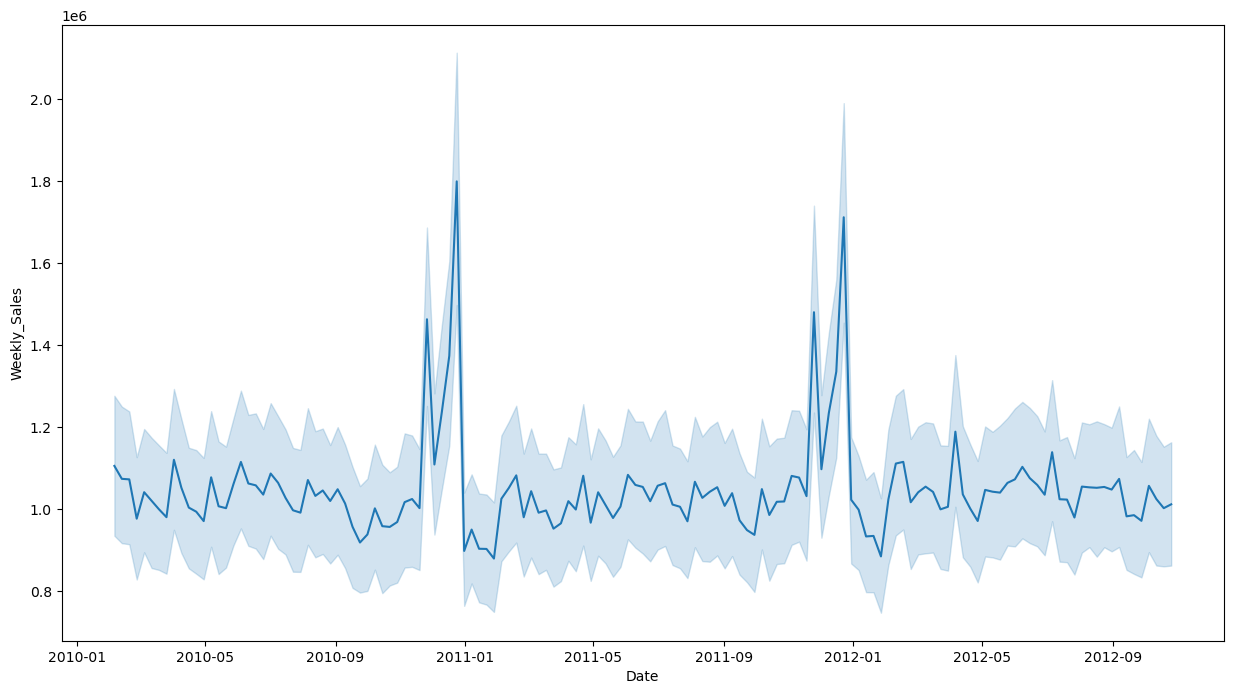

In [5]:
plt.figure(figsize=(15,8))
sns.lineplot(x= df['Date'], y= df['Weekly_Sales'])

# Model Preprocessing

In [6]:
df['Date'] = pd.to_datetime(df['Date'], format="%d-%m-%Y")
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day
df.drop('Date', axis=1, inplace=True)

In [7]:
X = df.drop(['Weekly_Sales'], axis=1)
y = df['Weekly_Sales']

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(), ['Store','Month', 'Day']),
        ('num', StandardScaler(), ['Year', 'Temperature', 'Fuel_Price', 'CPI', 'Unemployment'])
    ])

preprocessor.fit(X_train)

X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Model Architecture and Training

In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam

2024-02-16 17:00:55.087240: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [10]:
X_train_processed
# So I know what multiple of nodes to add to the network.
# In this case, 93*3

<5148x93 sparse matrix of type '<class 'numpy.float64'>'
	with 41184 stored elements in Compressed Sparse Row format>

In [11]:
model = Sequential()

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(279,activation='relu'))
model.add(Dropout(0.2))

model.add(Dense(1))

model.compile(optimizer='adam',loss='mae')

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=25)

In [13]:
model.fit(x=X_train_processed,y=y_train.values,
          validation_data=(X_test_processed,y_test.values),
          batch_size=32,epochs=2000,
          callbacks=[early_stop])

Epoch 1/2000
161/161 [==============================] - 3s 8ms/step - loss: 541323.0000 - val_loss: 216217.2812
Epoch 2/2000
161/161 [==============================] - 2s 10ms/step - loss: 148646.0000 - val_loss: 102265.7656
Epoch 3/2000
161/161 [==============================] - 2s 14ms/step - loss: 117995.1797 - val_loss: 82122.1016
Epoch 4/2000
161/161 [==============================] - 4s 22ms/step - loss: 112357.3984 - val_loss: 77113.1484
Epoch 5/2000
161/161 [==============================] - 3s 20ms/step - loss: 111746.0547 - val_loss: 72687.0312
Epoch 6/2000
161/161 [==============================] - 3s 19ms/step - loss: 108745.6328 - val_loss: 79896.9141
Epoch 7/2000
161/161 [==============================] - 3s 16ms/step - loss: 105334.2812 - val_loss: 74803.3594
Epoch 8/2000
161/161 [==============================] - 3s 19ms/step - loss: 105821.4609 - val_loss: 68219.3125
Epoch 9/2000
161/161 [==============================] - 4s 23ms/step - loss: 106943.0391 - val_loss: 70

# Model Evaluation
The following went though many, many iterations before I landed on a good number of layers, nodes per layer, and dropout rates.

<Axes: >

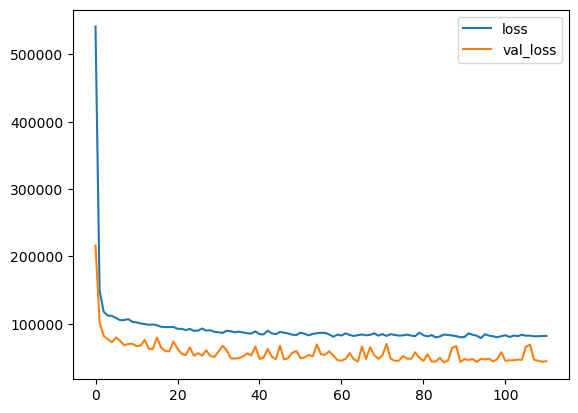

In [14]:
losses = pd.DataFrame(model.history.history)
losses.plot()

### I am incredibly pleased with an r2 score of 0.9859966854648519 and a MAE of 44568.51973484849. All things considered, since the Weekly_Sales column is dealing with millions of dollars, a prediction off by 44,000 or so is not so bad.

### Additionally, as the following chart shows, much of the error is due to large outliers which it underpredicts. These could be further adjusted for in a future, more accurate model.

In [15]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score, r2_score

predictions = model.predict(X_test_processed)

mae = mean_absolute_error(y_test,predictions)
rmse = np.sqrt(mean_squared_error(y_test,predictions))
evs = explained_variance_score(y_test,predictions)
r2 = r2_score(y_test, predictions)

print(mae)
print(r2)
print(rmse)
print(evs)

41/41 [==============================] - 0s 2ms/step
44568.51973484849
0.9859966854648519
67165.70328299917
0.9860184216448671


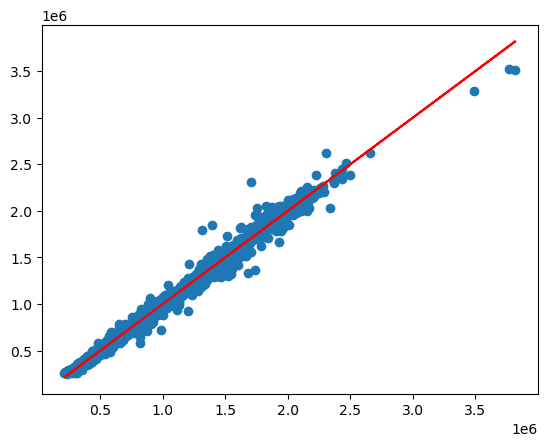

In [16]:
# Predictions
plt.scatter(y_test,predictions)

# Perfect predictions
plt.plot(y_test,y_test,'r')

### One final consideration for a future model is the possibility of data leakage when it comes to Year. Likely, this would not be known in a real-world situation or, if it was known, would bear no weight due to it being the present and not a historical value.